In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
base = pd.read_pickle('../data/base_df.pkl')
snli = pd.read_pickle('../data/english_snli_generate_class_shot.pkl')
tweet = pd.read_pickle('../data/english_tweet_eval_generate_class_shot.pkl')
sarcasmania = pd.read_pickle('../data/sarcasmania_generate_class_shot.pkl')
word_context = pd.read_pickle('../data/word_context_generate_class_shot.pkl')

snli['correctness'] = snli['ratio_'].map(lambda x: abs(1 - x))
tweet['correctness'] = tweet['ratio_'].map(lambda x: abs(1 - x))
sarcasmania['correctness'] = sarcasmania['ratio_'].map(lambda x: abs(1 - x))
word_context['correctness'] = word_context['ratio_'].map(lambda x: abs(1 - x))
base['correctness'] = base['ratio'].map(lambda x: abs(1 - x))

In [21]:
# change values in order_ column with {'AB': 'Maj-Min', 'BA': 'Min-Maj'} in sarcasmania
sarcasmania['order_'] = sarcasmania['order_'].map({'AB': 'Maj-Min', 'BA': 'Min-Maj'})
word_context['order_'] = word_context['order_'].map({'AB': 'Maj-Min', 'BA': 'Min-Maj'})
snli['order_'] = snli['order_'].map({'ABC': 'Maj-Min', 'CBA': 'Min-Maj'})
tweet['order_'] = tweet['order_'].map({'ADBC': 'Maj-Min', 'CBDA': 'Min-Maj'})

sarcasmania.fillna('None', inplace=True)
word_context.fillna('None', inplace=True)
snli.fillna('None', inplace=True)
tweet.fillna('None', inplace=True)
base.fillna('None', inplace=True)


In [22]:
def f1_analysis(df, model, num_classes=2):
    df = df[df['correctness'] == 1]  #[df['fewshot_'] >= 1]
    df = df[df['model_'] == model]
    # get all values of fewshot_ column. If there is 'None' in order, get all the values and map them. The smallest one map to 1n, the second smallest to 2n, and so on.
    fewshot_values = df[df['order_'] == 'None']['fewshot_'].unique()
    fewshot_values = sorted(fewshot_values)
    df['fewshot_key'] = df['fewshot_']
    df_none = df[df['permutation_'] == 'None']
    df_none['fewshot_key'] = df_none['fewshot_'].map({i: f'{k}' for i, k in zip(fewshot_values, [0, 1, 2, 3])})
    df_not_none = df[df['permutation_'] != 'None']
    df = pd.concat([df_none, df_not_none])
    return df[
        ((df['order_'] == 'Maj-Min') & (df['permutation_'] == 'ABC') & (df['fewshot_'] == 1)) |
        ((df['permutation_'] == 'RANDOM') & (df['fewshot_'] == 1)) |
        ((df['order_'] == 'Maj-Min') & (df['permutation_'] == 'ABC') & (df['fewshot_'] == 2)) |
        ((df['permutation_'] == 'RANDOM') & (df['fewshot_'] == 2)) |
        ((df['order_'] == 'Maj-Min') & (df['permutation_'] == 'ABC') & (df['fewshot_'] == 3)) |
        ((df['permutation_'] == 'RANDOM') & (df['fewshot_'] == 3)) |
        ((df['permutation_'] == 'None'))
        ][
        ['fewshot_', 'permutation_', 'order_', 'mean_f1_mean', 'mean_f1_std', 'accuracy_mean', 'model_', 'fewshot_key',
         'task_']]

In [23]:
results = []
stds = []
for dataset in [snli, tweet, sarcasmania, word_context]:
    for name in ['meta-llama/Llama-3.1-8B-Instruct', 'meta-llama/Llama-3.3-70B-Instruct',
                 'mistralai/Mixtral-8x7B-Instruct-v0.1']:
        res = f1_analysis(dataset, name)
        results.append(res)

        res['F1_percent_change'] = res.groupby(['order_', 'permutation_'])['mean_f1_mean'].pct_change() * 100
        f1_order_0 = res.loc[res['fewshot_'] == 0, 'mean_f1_mean'].values[0]

        # Update F1_diff for rows where Order == 1
        res.loc[res['fewshot_'] == 1, 'F1_percent_change'] = ((res.loc[res[
                                                                           'fewshot_'] == 1, 'mean_f1_mean'] - f1_order_0) / f1_order_0) * 100

        if (name == 'meta-llama/Llama-3.3-70B-Instruct' and dataset['task_'].iloc[0] == 'sarcasmania_generate_class_shot'):
            continue
        stds.append(res)

final_all = pd.concat(results)
std_all = pd.concat(stds)

/tmp/ipykernel_14545/645547522.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_none['fewshot_key'] = df_none['fewshot_'].map({i: f'{k}' for i, k in zip(fewshot_values, [0, 1, 2, 3])})
/tmp/ipykernel_14545/645547522.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_none['fewshot_key'] = df_none['fewshot_'].map({i: f'{k}' for i, k in zip(fewshot_values, [0, 1, 2, 3])})
/tmp/ipykernel_14545/645547522.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

In [24]:
final_all.to_pickle('../data/f1_all.pkl')
std_all.to_pickle('../data/std_all.pkl')

In [25]:
llm_big = final_all.loc[
    (final_all['model_'] == 'meta-llama/Llama-3.3-70B-Instruct') &
    (final_all['task_'] != 'sarcasmania_generate_class_shot')
    ].groupby(['fewshot_key', 'permutation_']).mean().reset_index()
llm_small = final_all[final_all['model_'] == 'meta-llama/Llama-3.1-8B-Instruct'].groupby(
    ['fewshot_key', 'permutation_']).mean().reset_index()
mix = final_all[final_all['model_'] == 'mistralai/Mixtral-8x7B-Instruct-v0.1'].groupby(
    ['fewshot_key', 'permutation_']).mean().reset_index()

In [26]:
llm_big['fewshot_key'] = llm_big['fewshot_key'].map(lambda x: int(x))
llm_small['fewshot_key'] = llm_small['fewshot_key'].map(lambda x: int(x))
mix['fewshot_key'] = mix['fewshot_key'].map(lambda x: int(x))

In [27]:
series_1_ = llm_small[llm_small['fewshot_key'] == 1][['permutation_', 'mean_f1_mean', 'mean_f1_std']]
series_2_ = llm_small[llm_small['fewshot_key'] == 2][['permutation_', 'mean_f1_mean', 'mean_f1_std']]
series_3_ = llm_small[llm_small['fewshot_key'] == 3][['permutation_', 'mean_f1_mean', 'mean_f1_std']]

keys = list(series_1_['permutation_'].values)[::-1]

series_0 = list(llm_small[llm_small['fewshot_key'] == 0][['mean_f1_mean']].iloc[0])
series_1 = list(series_1_['mean_f1_mean'].values)[::-1]
series_2 = list(series_2_['mean_f1_mean'].values)[::-1]
series_3 = list(series_3_['mean_f1_mean'].values)[::-1]

series_0_std = list(llm_small[llm_small['fewshot_key'] == 0][['mean_f1_std']].iloc[0])
series_1_std = list(series_1_['mean_f1_std'].values)[::-1]
series_2_std = list(series_2_['mean_f1_std'].values)[::-1]
series_3_std = list(series_3_['mean_f1_std'].values)[::-1]


In [30]:
categories = [0, 1, 2, 3]
x = np.arange(len(categories))

def create_fewshot_plot(ax, series_0, series_1, series_2, series_3, series_1_std, series_2_std, series_3_std, name):
    categories = ['(n*num_classes)-few-shot', 'class-n-shot RANDOM', 'class-n-shot Maj-Min altering']
    data_series = [series_0, series_1, series_2, series_3]
    data_std = [None, series_1_std, series_2_std, series_3_std]
    labels = ['Zero-Shot', '1', '2', '3']
    colors = ['#E2A6B5', '#F6C1B5', '#A8D5BA']
    zero_color = '#A2A6B5'

    # Initialize plot
    x = np.arange(len(labels))
    bar_width = 0.28
    sns.set_theme(style="whitegrid", palette="pastel")

    # Plot bars where each group represents a few-shot setting
    for i, (series, std) in enumerate(zip(data_series, data_std)):
        if i == 0:
            # Zero-shot has only one value, so center it across categories
            ax.bar(x[i] + bar_width, series[0], width=bar_width,  #label=categories[0],
                   color=zero_color, edgecolor='black', linewidth=0.8, alpha=0.9)
            ax.text(x[i] + bar_width, series[0] + 0.02, f"{series[0]:.3f}",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
        else:
            for j, (value, error, color, category) in enumerate(zip(series, std, colors, categories)):
                bar = ax.bar(x[i] + j * bar_width, value, width=bar_width, yerr=error, capsize=4,
                             label=category if i == 1 else "",
                             color=color, edgecolor='black', linewidth=0.8, alpha=0.9)
                ax.text(bar[0].get_x() + bar[0].get_width() / 2, bar[0].get_height() + 0.02, f"{value:.3f}",
                        ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax.set_xlabel('n-shot', fontsize=12, fontweight='bold')
    ax.set_ylabel('F1', fontsize=12, fontweight='bold')
    ax.set_title(name, fontsize=16, fontweight='bold', pad=10)
    ax.set_xticks(x + bar_width)
    ax.set_xticklabels(labels, fontsize=12)
    ax.set_ylim(0, 0.85)
    ax.grid(axis='y', color='gray', linestyle='--', linewidth=0.5, alpha=0.7)


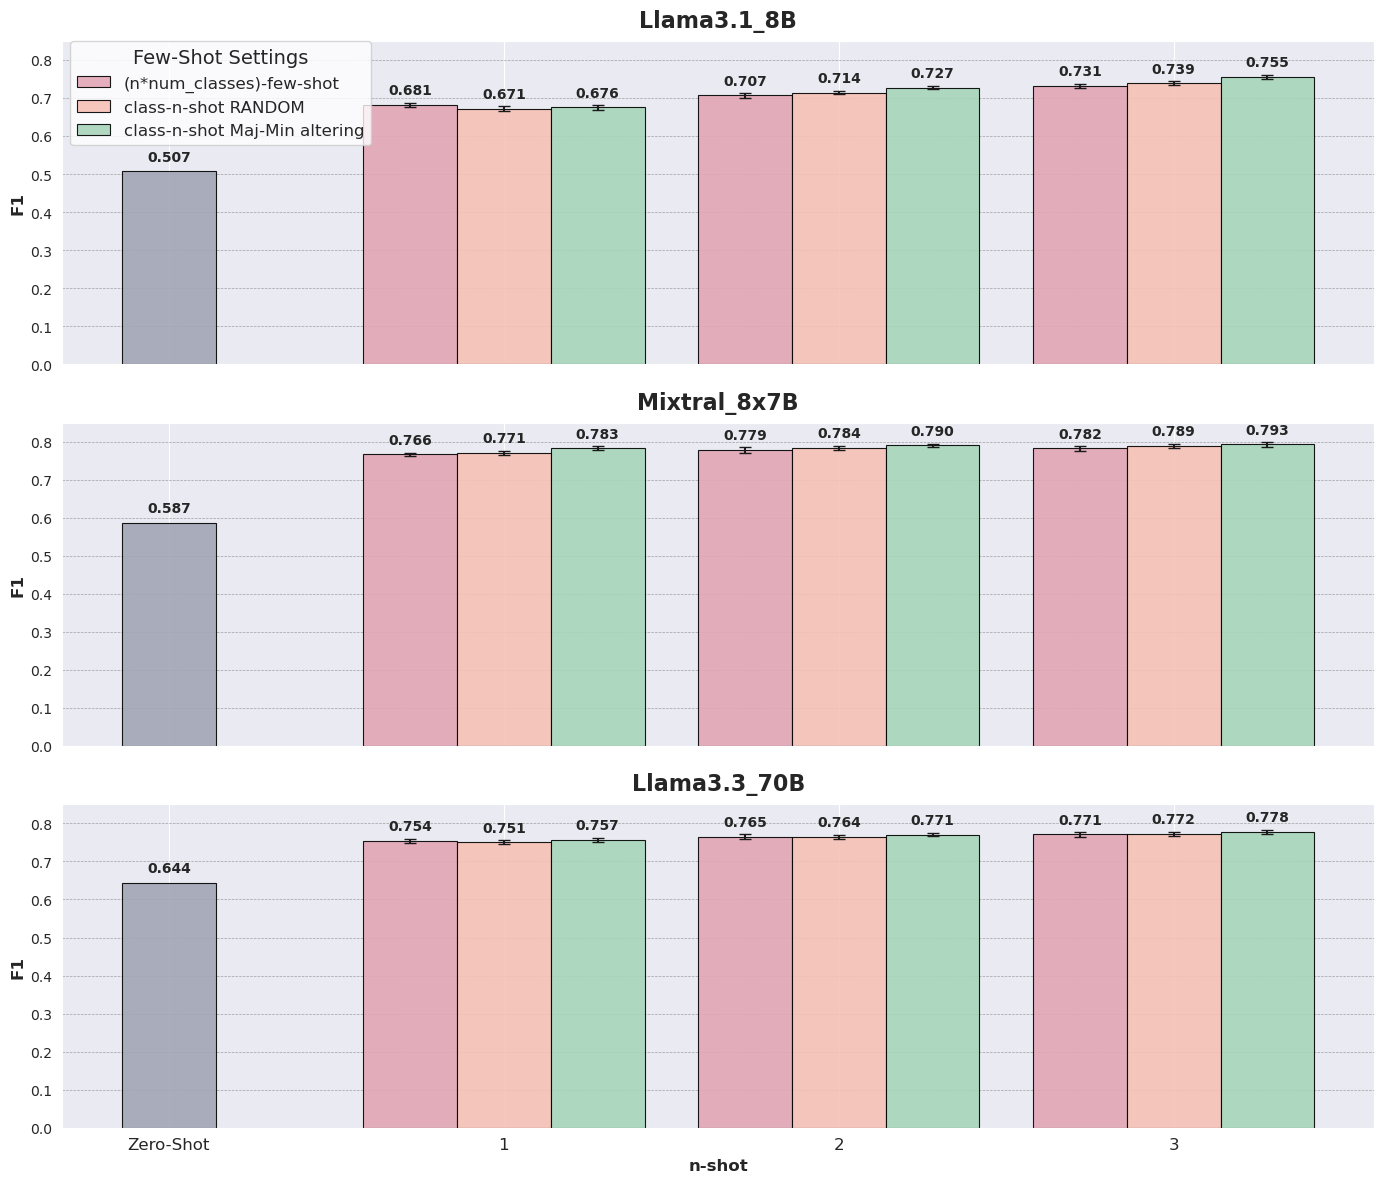

In [31]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
for df, ax, name in zip([llm_small, mix, llm_big], axes, ['''Llama3.1_8B''', 'Mixtral_8x7B', 'Llama3.3_70B']):
    series_1_ = df[df['fewshot_key'] == 1][['permutation_', 'mean_f1_mean', 'mean_f1_std']]
    series_2_ = df[df['fewshot_key'] == 2][['permutation_', 'mean_f1_mean', 'mean_f1_std']]
    series_3_ = df[df['fewshot_key'] == 3][['permutation_', 'mean_f1_mean', 'mean_f1_std']]

    keys = list(series_1_['permutation_'].values)[::-1]

    series_0 = list(df[df['fewshot_key'] == 0][['mean_f1_mean']].iloc[0])
    series_1 = list(series_1_['mean_f1_mean'].values)[::-1]
    series_2 = list(series_2_['mean_f1_mean'].values)[::-1]
    series_3 = list(series_3_['mean_f1_mean'].values)[::-1]

    series_0_std = list(df[df['fewshot_key'] == 0][['mean_f1_std']].iloc[0])
    series_1_std = list(series_1_['mean_f1_std'].values)[::-1]
    series_2_std = list(series_2_['mean_f1_std'].values)[::-1]
    series_3_std = list(series_3_['mean_f1_std'].values)[::-1]

    create_fewshot_plot(ax, series_0, series_1, series_2, series_3, series_1_std, series_2_std, series_3_std, name)
for ax in axes[:-1]:
    ax.set_xlabel('')
handles, labels = axes[0].get_legend_handles_labels()
sns.set_theme(style="whitegrid", palette="pastel")
fig.legend(handles, labels, title="Few-Shot Settings", fontsize=12, title_fontsize=14,
           loc='upper left', bbox_to_anchor=(0.05, 0.965), ncol=1, frameon=True, fancybox=True)

plt.tight_layout()
plt.savefig("combined_f1_plot.jpg")
plt.show()
#     create_fewshot_plot(ax, series_0, series_1, series_2, series_3, series_1_std, series_2_std, series_3_std, name)